### Random Forest Classifier is used in this Kernel. Dashboard score is 0.78468

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import re
#Sklearn OneHot Encoder to Encode categorical integer features
from sklearn.preprocessing import OneHotEncoder
#Sklearn train_test_split to split a set on train and test 
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split      # for old sklearn version use this to split a dataset 
# Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

In [2]:
#Import the training data set
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
#Construct an X matrix
x_train = data[['Name', 'Pclass','Sex','Age','Parch','SibSp','Embarked', 'Fare', 'Cabin', 'Survived']].copy()
x_test = test[['Name', 'Pclass','Sex','Age','Parch','SibSp','Embarked', 'Fare', 'Cabin']].copy()
x_train.shape, x_test.shape

((891, 10), (418, 9))

In [6]:
PassengerID = np.array(test['PassengerId'])

## Embarked data

In [7]:
print(x_train.Embarked.unique())
print(x_test.Embarked.unique())
set(x_train.Embarked.unique()) == set(x_test.Embarked.unique())   # CHeck that values in the train and in the test were similar

['S' 'C' 'Q' nan]
['Q' 'S' 'C']


False

So, there is a NaN value in the train data, only 2 rows, as we have seen ealier, lets drop them

In [8]:
x_train = x_train.dropna(subset=['Embarked'],axis=0)

In [9]:
print(x_train.Embarked.unique())
set(x_train.Embarked.unique())==set(x_test.Embarked.unique())   # CHeck that values in the train and in the test were similar

['S' 'C' 'Q']


True

 replace these values with (0,1,2)

In [10]:
x_train.Embarked = pd.factorize(x_train.Embarked)[0]
x_test.Embarked = pd.factorize(x_test.Embarked)[0]

In [11]:
x_train.head()

,Name,Pclass,Sex,Age,Parch,SibSp,Embarked,Fare,Cabin,Survived
0,"Braund, Mr. Owen Harris",3,male,22.0,0,1,0,7.2500,NaN,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,0,1,1,71.2833,C85,1
2,"Heikkinen, Miss. Laina",3,female,26.0,0,0,0,7.9250,NaN,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,0,1,0,53.1000,C123,1
4,"Allen, Mr. William Henry",3,male,35.0,0,0,0,8.0500,NaN,0


## Sex data

There are np missed values so factorize these values (0,1)

In [12]:
x_train.Sex = pd.factorize(x_train.Sex)[0]
x_test.Sex = pd.factorize(x_test.Sex)[0]

## Sibsp and Parch data
#### We should be carefull with these data to not overfit our model. Lets create a Family feature, which show a size of family, and the feture which show is a passenger alone

In [13]:
x_train['Family'] = x_train['SibSp'] + x_train['Parch']
x_test['Family'] = x_test['SibSp'] + x_test['Parch']

x_train['Alone'] = x_train['Family'].map(lambda x: 1 if x==0 else 0)
x_test['Alone'] = x_test['Family'].map(lambda x: 1 if x==0 else 0)

## Age data

### I am going to firstly categorize these data and after make a factorization. But first of all lets define how to categorize the Ages, what intervals will be most efficient, and how to deal with missed values

In [14]:
# Find a mean Age in overall data
age = pd.concat([x_test.Age, x_train.Age], axis=0)

In [15]:
mean = age[1].mean()

In [16]:
# Identify the rows with missed Age in special column
x_train['Missed_Age'] = x_train['Age'].map(lambda x: 1 if pd.isnull(x)  else 0)
x_test['Missed_Age'] = x_test['Age'].map(lambda x: 1 if pd.isnull(x) else 0)

In [17]:
# Fill all age values with Age mean
x_train['Age'] = x_train['Age'].fillna(mean)
x_test['Age'] = x_test['Age'].fillna(mean)

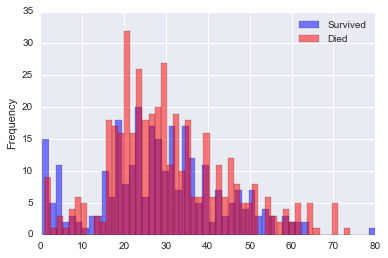

In [18]:
data[data.Survived==1].Age.plot.hist(alpha=0.5,color='blue',stacked=True, bins=50)
data[data.Survived==0].Age.plot.hist(alpha=0.5,color='red', stacked=True, bins=50)
plt.legend(['Survived','Died'])
plt.show()

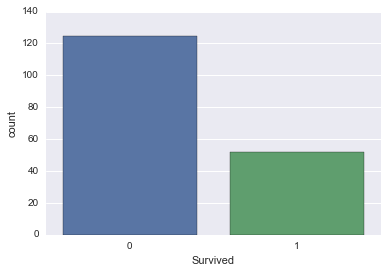

In [19]:
sns.countplot(x="Survived", data=data[data['Age'].isnull()])

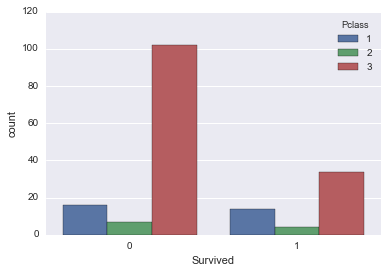

In [20]:
sns.countplot(x="Survived", data=data[data['Age'].isnull()], hue='Pclass')

In [21]:
def process_age(df,cut_points,label_names):
    df["Age"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,16,100]        
label_names = [0,1,2,3]

x_train = process_age(x_train,cut_points,label_names)
x_test = process_age(x_test,cut_points,label_names)

In [22]:
set(x_train['Age'].unique()) == set(x_test['Age'].unique())

True

In [23]:
x_train.head()

,Name,Pclass,Sex,Age,Parch,SibSp,Embarked,Fare,Cabin,Survived,Family,Alone,Missed_Age
0,"Braund, Mr. Owen Harris",3,0,3,0,1,0,7.2500,NaN,0,1,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,3,0,1,1,71.2833,C85,1,1,0,0
2,"Heikkinen, Miss. Laina",3,1,3,0,0,0,7.9250,NaN,1,0,1,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,3,0,1,0,53.1000,C123,1,1,0,0
4,"Allen, Mr. William Henry",3,0,3,0,0,0,8.0500,NaN,0,0,1,0


## Fare data

In [24]:
# Fill one missed fare in the train set with mean Fare for this class
x_test.loc[x_test['Fare'].isnull()]['Pclass']  # determine a Class for this passenger

152    3
Name: Pclass, dtype: int64

In [25]:
# Find the mean Fare for Class 3
fare_mean = pd.concat([x_train.loc[x_train['Pclass']==3]['Fare'], x_test.loc[x_test['Pclass']==3]['Fare']], axis=0).mean()

In [26]:
# Fill the data gap
x_test['Fare'] = x_test['Fare'].fillna(fare_mean)

In [27]:
x_test.isnull().sum()

Name            0
Pclass          0
Sex             0
Age             0
Parch           0
SibSp           0
Embarked        0
Fare            0
Cabin         327
Family          0
Alone           0
Missed_Age      0
dtype: int64

In [28]:
x_train['Fare'] = (x_train['Fare']/20).astype('int64')
x_test['Fare'] = (x_test['Fare']/20).astype('int64')

In [29]:
set(x_train['Fare'].unique()) == set(x_test['Fare'].unique()) # Check the train and test data identity

True

## Cabin data

In [30]:
# There a lot of missed values so lets just check do passenger have a Cabin number or not

In [31]:
x_train['Missed_Cabin'] = x_train['Cabin'].map(lambda x: 0 if pd.isnull(x)  else 1)
x_test['Missed_Cabin'] = x_test['Cabin'].map(lambda x: 0 if pd.isnull(x) else 1)

Also we can see that some passenger has a few cabins number, lets make a special column, where missed cabin will be zero, 
and 1,2.... so on the number of cabins

In [32]:
x_train['Cabin_num'] = x_train['Cabin'].map(lambda x: 0 if pd.isnull(x)  else len(x.split()))
x_test['Cabin_num'] = x_test['Cabin'].map(lambda x: 0 if pd.isnull(x) else len(x.split()))

In [33]:
x_train.head()

,Name,Pclass,Sex,Age,Parch,SibSp,Embarked,Fare,Cabin,Survived,Family,Alone,Missed_Age,Missed_Cabin,Cabin_num
0,"Braund, Mr. Owen Harris",3,0,3,0,1,0,0,NaN,0,1,0,0,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,3,0,1,1,3,C85,1,1,0,0,1,1
2,"Heikkinen, Miss. Laina",3,1,3,0,0,0,0,NaN,1,0,1,0,0,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,3,0,1,0,2,C123,1,1,0,0,1,1
4,"Allen, Mr. William Henry",3,0,3,0,0,0,0,NaN,0,0,1,0,0,0


## Name data

In [34]:
# Lets try to extract a Title data from name using regular expression
x_train['Title'] = x_train['Name'].map(lambda x: str(re.findall("^.*[, *](.*)[.] *", x)[0]))
x_test['Title'] = x_test['Name'].map(lambda x: str(re.findall("^.*[, ](.*)[.] *", x)[0]))

In [35]:
x_train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'L', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

By the way - Wiki: Count (male) or countess (female) is a title in European countries for a noble of varying status, but historically deemed to convey an approximate rank intermediate between the highest and lowest titles of nobility

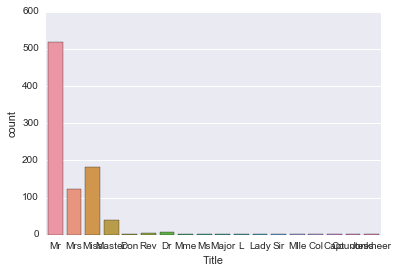

In [36]:
sns.countplot(x="Title", data=x_train)

In [37]:
x_train.Title = pd.factorize(x_train.Title)[0]
x_test.Title = pd.factorize(x_test.Title)[0]

In [38]:
x_train.head()

,Name,Pclass,Sex,Age,Parch,SibSp,Embarked,Fare,Cabin,Survived,Family,Alone,Missed_Age,Missed_Cabin,Cabin_num,Title
0,"Braund, Mr. Owen Harris",3,0,3,0,1,0,0,NaN,0,1,0,0,0,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,3,0,1,1,3,C85,1,1,0,0,1,1,1
2,"Heikkinen, Miss. Laina",3,1,3,0,0,0,0,NaN,1,0,1,0,0,0,2
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,3,0,1,0,2,C123,1,1,0,0,1,1,1
4,"Allen, Mr. William Henry",3,0,3,0,0,0,0,NaN,0,0,1,0,0,0,0


Lets also count define length

In [39]:
x_train['Name_Len_char'] = x_train['Name'].map(lambda x: len(x))
x_train['Name_Len_words'] = x_train['Name'].map(lambda x: len(x.split()))

x_test['Name_Len_char'] = x_test['Name'].map(lambda x: len(x))
x_test['Name_Len_words'] = x_test['Name'].map(lambda x: len(x.split()))

In [40]:
x_train.head()

,Name,Pclass,Sex,Age,Parch,SibSp,Embarked,Fare,Cabin,Survived,Family,Alone,Missed_Age,Missed_Cabin,Cabin_num,Title,Name_Len_char,Name_Len_words
0,"Braund, Mr. Owen Harris",3,0,3,0,1,0,0,NaN,0,1,0,0,0,0,0,23,4
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,3,0,1,1,3,C85,1,1,0,0,1,1,1,51,7
2,"Heikkinen, Miss. Laina",3,1,3,0,0,0,0,NaN,1,0,1,0,0,0,2,22,3
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,3,0,1,0,2,C123,1,1,0,0,1,1,1,44,7
4,"Allen, Mr. William Henry",3,0,3,0,0,0,0,NaN,0,0,1,0,0,0,0,24,4


Create Y-array with SUrvived values

In [41]:
#Create Y array
y = np.array(x_train[['Survived']])
print(y.shape)

(889, 1)


Drop Columns which we do not need

In [42]:
x_train=x_train.drop(['SibSp', 'Parch', 'Name', 'Cabin', 'Survived'], axis=1)
x_test=x_test.drop(['SibSp', 'Parch', 'Name', 'Cabin'],axis=1)

In [43]:
x_train.head()

,Pclass,Sex,Age,Embarked,Fare,Family,Alone,Missed_Age,Missed_Cabin,Cabin_num,Title,Name_Len_char,Name_Len_words
0,3,0,3,0,0,1,0,0,0,0,0,23,4
1,1,1,3,1,3,1,0,0,1,1,1,51,7
2,3,1,3,0,0,0,1,0,0,0,2,22,3
3,1,1,3,0,2,1,0,0,1,1,1,44,7
4,3,0,3,0,0,0,1,0,0,0,0,24,4


Create Test and Train sets

In [44]:
xn_train, xn_test, yn_train, yn_test = train_test_split(x_train, y, test_size=0.3, random_state=32)
xn_train.shape, xn_test.shape, yn_train.shape, yn_test.shape

((622, 13), (267, 13), (622, 1), (267, 1))

In [45]:
# We can optimize the parameters using special function in sclearn, but here I will do it manually
C=np.array([100,150,200,250,300,350,400,450,500,550,600,650,700,750])
scores = np.zeros(C.shape)
for i in range (len(C)):
        clf = RandomForestClassifier(n_estimators = int(C[i]), max_depth=10, random_state=0, criterion='entropy') 
        clf.fit(xn_train, yn_train) 
        scores[i] = clf.score(xn_test,yn_test)

C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:6: DataConversionWarning: A column-vec

In [46]:
ind = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
print('max Score = ',scores[ind],'\noptimal C = ',C[ind])

max Score =  0.835205992509 
optimal C =  150


In [47]:
clf = RandomForestClassifier(n_estimators = 150, max_depth=10, random_state=0, criterion='entropy') 
clf.fit(xn_train, yn_train) 
print(clf.score(xn_train,yn_train))
print(clf.score(xn_test,yn_test))

0.946945337621
0.835205992509


C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [48]:
importance = clf.feature_importances_

In [49]:
importance = pd.DataFrame(importance, index=x_test.columns, 
                          columns=["Importance"])

In [50]:
print(importance)

                Importance
Pclass            0.080564
Sex               0.156409
Age               0.035091
Embarked          0.039036
Fare              0.076543
Family            0.080330
Alone             0.018563
Missed_Age        0.020457
Missed_Cabin      0.039812
Cabin_num         0.045752
Title             0.166855
Name_Len_char     0.178008
Name_Len_words    0.062578


In [51]:
clf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state=0, criterion='entropy') 
clf.fit(x_train, y) 
prediction = clf.predict(x_test)

C:\Roman Kutskyi\Anaconda\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [52]:
print(clf.score(xn_train,yn_train))
print(clf.score(xn_test,yn_test))
print(clf.score(x_train,y))

0.926045016077
0.936329588015
0.929133858268


In [53]:
# Submit the result

submission_df = {"PassengerId": PassengerID,
                 "Survived": prediction}
submission = pd.DataFrame(submission_df)

In [54]:
submission.to_csv("submission_rf3.csv",index=False)